In [1]:
import pandas as pd


fname = "historico_itajai_0.txt"
df = pd.read_csv(fname, index_col="# Datetime", parse_dates=True, na_values="-9999.0")

df.columns = df.columns.str.lower()
df.index.name = "datetime"

In [2]:
df = df.dropna(how="all", axis=0)


# Also drop those where we don't have the location.
df = df.loc[~df["lon"].isnull()]
df = df.loc[~df["lat"].isnull()]

In [3]:
import io

table = """
deployment,recovery,lat,lon
23/04/2009,10/12/2009,28°29.20'S,047°31.50'W
17/02/2011,03/10/2012,28°29.867'S,047°21.63'W
01/02/2013,26/09/2013,28°29.077'S,047°21.599'W
06/11/2014,29/10/2015,28°31.14'S,047°23.42'W
10/04/2016,03/02/2017,28°30.926'S,047°23.470'W
04/02/2017,03/09/2019,27°24.36'S,047°15.93'W
"""

table = pd.read_csv(io.StringIO(table), parse_dates=["deployment", "recovery"], dayfirst=True)

In [4]:
def fix_pos(pos):
    deg, rest = pos.split("°")
    m, d = rest.split("'")

    if d in ["S", "W"]:
        sign = -1
    elif d in ["N", "E"]:
        sign = 1
    else:
        raise ValueError(f"Unregonized sign {d}.")

    return sign*(float(deg) + float(m)/60.)

In [5]:
table["lat"] = table["lat"].apply(fix_pos)
table["lon"] = table["lon"].apply(fix_pos)

In [6]:
deployments = {}
for (k, row) in table.iterrows():
    begin, end = row[["deployment", "recovery"]]
    sliced = df.loc[begin:end]
    deployments.update({k: sliced})

records = [deployments[key].shape[0] for key in deployments.keys()]
table["records"] = records

## Deployment 5 is the closest to the wells

In [7]:
wells = {
    "FPSO": {  # FPSO Cidade de Itajaí
        "lat": -26.4666383,
        "lon": -46.5286883,
    },
    "BRSA": {  # Poço 3-BRSA-1024
        "lat": -26.4162525,
        "lon": -46.4819844,
    },
}

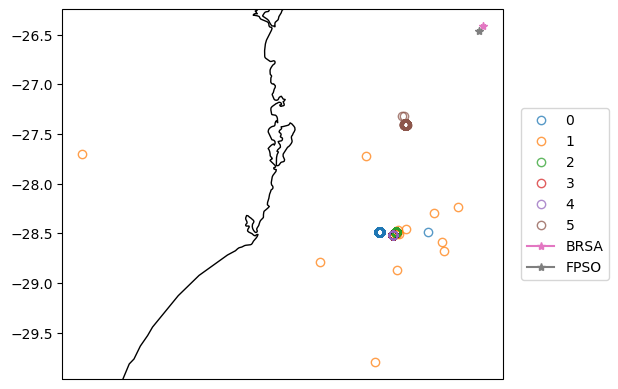

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


projection = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw={"projection": projection})

for (k, sliced) in deployments.items():
    sliced.plot(
        x="lon",
        y="lat",
        ax=ax,
        marker="o",
        markerfacecolor="none",
        linestyle="none",
        alpha=0.75,
        label=k
    )


ax.plot(wells["BRSA"]["lon"], wells["BRSA"]["lat"], label="BRSA", marker="*")
ax.plot(wells["FPSO"]["lon"], wells["FPSO"]["lat"], label="FPSO", marker="*")

# ax.set_extent([lon_min, lon_max, lat_min, lat_max])
c = ax.coastlines()
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);

In [9]:
df = deployments[5]

deployment, recovery, lat, lon, records = table.loc[5]

print(
    f"Deployment 5 was installed at {lon=}, {lat=}\n"
    f"From {deployment:%d-%b-%Y} to {recovery:%d-%b-%Y}\n"
    f"With {records} records."
)

Deployment 5 was installed at lon=-47.2655, lat=-27.406
From 04-Feb-2017 to 03-Sep-2019
With 15980 records.


## Waves

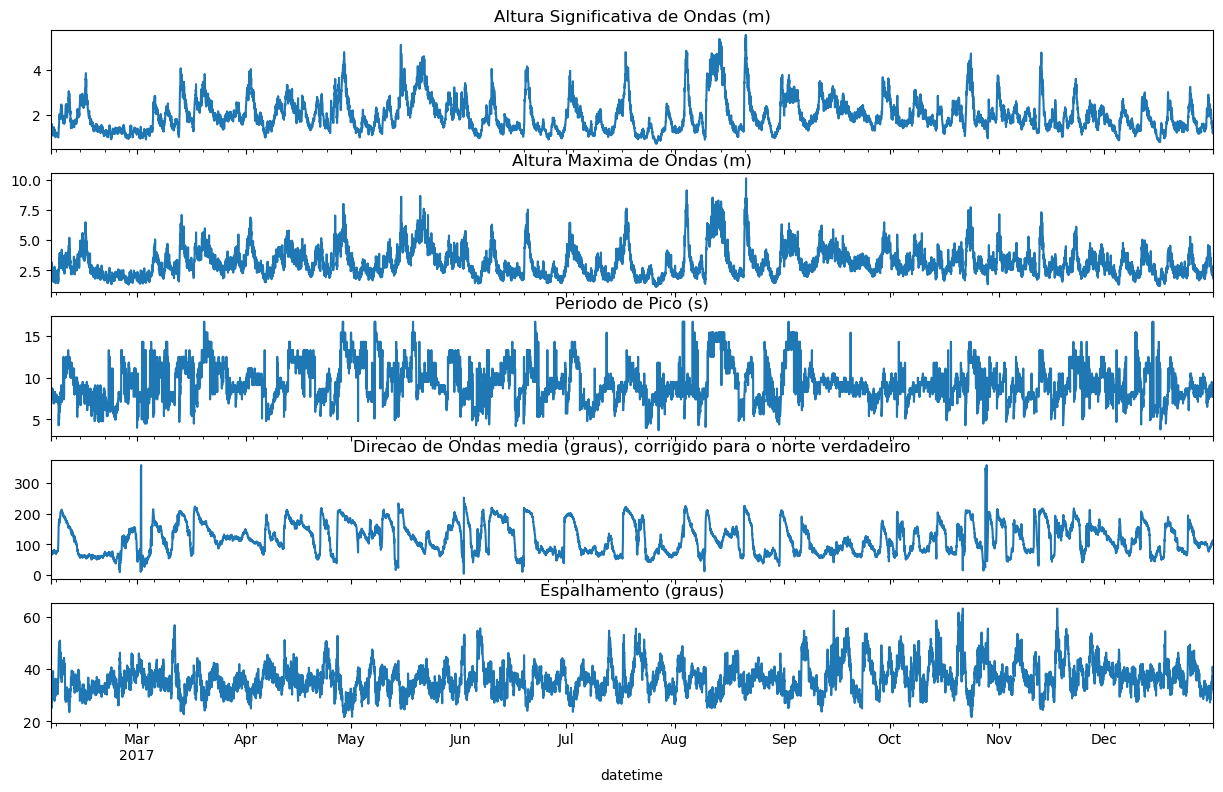

In [10]:
fig, axes = plt.subplots(
    figsize=(15, 9), nrows=5, ncols=1,
    sharex=True,
)

deployment = 5
df = deployments[5].loc["2017"]

df["wvht"].plot(ax=axes[0])
axes[0].set_title("Altura Significativa de Ondas (m)")

df["wmax"].plot(ax=axes[1])
axes[1].set_title("Altura Maxima de Ondas (m)")

df["dpd"].plot(ax=axes[2])
axes[2].set_title("Periodo de Pico (s)")

df["mwd"].plot(ax=axes[3])
axes[3].set_title("Direcao de Ondas media (graus), corrigido para o norte verdadeiro")

df["spread"].plot(ax=axes[4])
axes[4].set_title("Espalhamento (graus)");

## Meteo

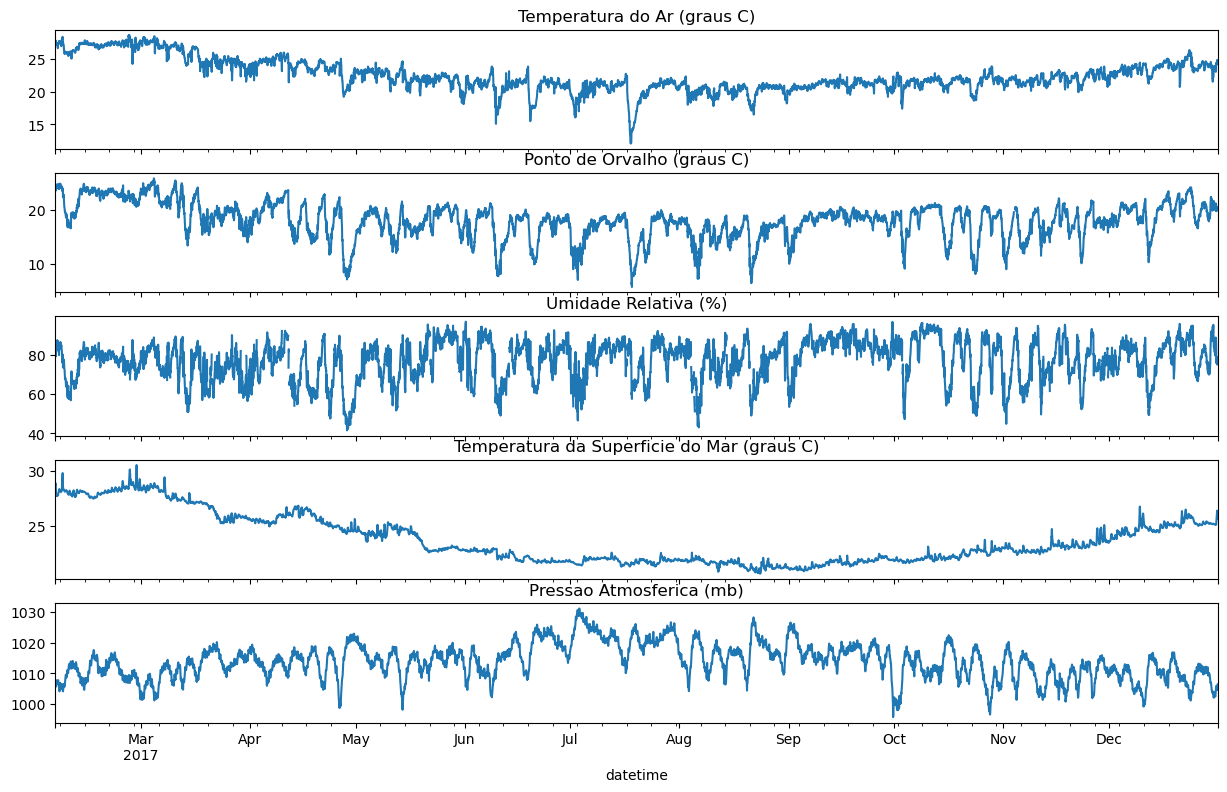

In [11]:
fig, axes = plt.subplots(
    figsize=(15, 9), nrows=5, ncols=1,
    sharex=True,
)

df["atmp"].plot(ax=axes[0])
axes[0].set_title("Temperatura do Ar (graus C)")

df["dewp"].plot(ax=axes[1])
axes[1].set_title("Ponto de Orvalho (graus C)")

df["humi"].plot(ax=axes[2])
axes[2].set_title("Umidade Relativa (%)")

df["wtmp"].plot(ax=axes[3])
axes[3].set_title("Temperatura da Superficie do Mar (graus C)")

df["pres"].plot(ax=axes[4])
axes[4].set_title("Pressao Atmosferica (mb)");

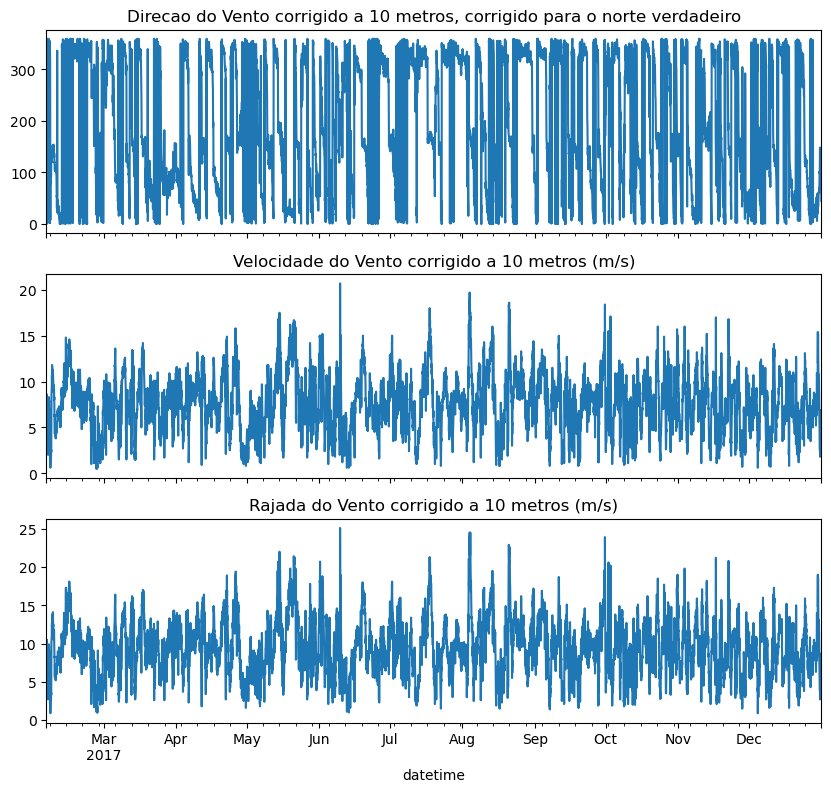

In [12]:
fig, axes = plt.subplots(
    figsize=(10, 9), nrows=3, ncols=1,
    sharex=True,
)

df["wdir"].plot(ax=axes[0])
axes[0].set_title("Direcao do Vento corrigido a 10 metros, corrigido para o norte verdadeiro")

df["wspd"].plot(ax=axes[1])
axes[1].set_title("Velocidade do Vento corrigido a 10 metros (m/s)")

df["gust"].plot(ax=axes[2])
axes[2].set_title("Rajada do Vento corrigido a 10 metros (m/s)");

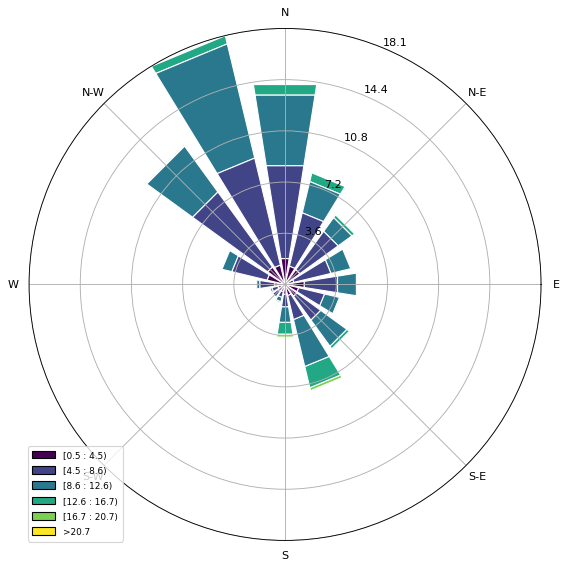

In [13]:
from windrose import WindroseAxes


ax = WindroseAxes.from_ax()
ax.bar(df["wdir"], df["wspd"], normed=True, opening=0.8, edgecolor="white")
ax.set_legend();

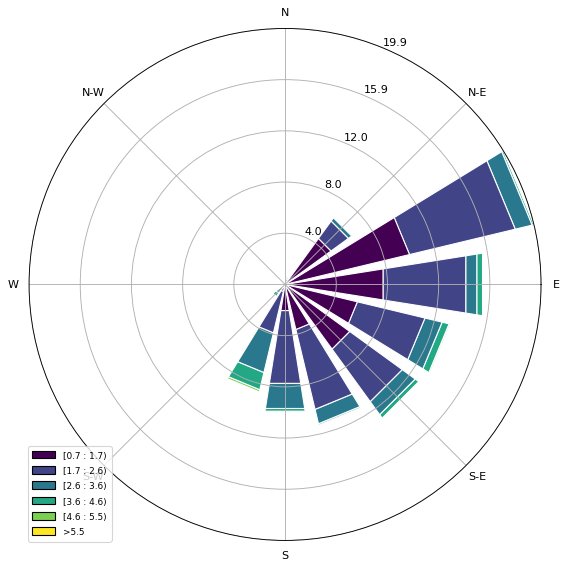

In [14]:
from windrose import WindroseAxes


ax = WindroseAxes.from_ax()
ax.bar(df["mwd"], df["wvht"], normed=True, opening=0.8, edgecolor="white")
ax.set_legend();